# This notebook explore using traditional  machine learning models to predict the price of a house based on its description.

In [20]:
import sys
import os
# Add the project root to sys.path
project_root = os.path.abspath("..")  # Move one level up to the project root
os.chdir("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    # change working directory to project root

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
import dotenv
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# Constants 0 used for printing to stdout in color
RED = "\033[91m"
GREEN = "\033[92m"
YELLOW = "\033[93m"
RESET = "\033[0m"
COLOR_MAP = {"red": RED, "yellow": YELLOW, "green": GREEN, "reset": RESET}

In [10]:
# environment vairables
dotenv.load_dotenv()

# openai_llm = ChatOpenAI(model="gpt-4o-mini")
# anthropic_llm = ChatAnthropic(model="claude-3-sonnet-20240229")

True

## 1. Load the dataset from `data_preparation.ipynb`

In [23]:
# Now import the modules
import pickle
from utils.items import Item

# Add an alias in sys.modules
sys.modules['items'] = sys.modules['utils.items']

with open('data/train.pkl', 'rb') as f:
    train = pickle.load(f, encoding='latin1')

with open('data/test.pkl', 'rb') as f:
    test = pickle.load(f)

In [24]:
train[0].test_prompt()

'How much does this cost to the nearest dollar?\n\nAT-A-GLANCE Daily Appointment Book 2015, 4.88 x 8 Inch Page Size, Black\nAround-the-clock planning, 24 hours a day, 7 days a week for the full year. Includes military and standard times with one day per page and hourly appointments, 12 p.m., including weekends. 12 months of planning power, January–December; 4.88 x 8 inch page size; 5.81 x 8.31 x.38 inches overall; Julian dates. One day per page; notes space; past, current and two future months reference. Printed on quality recycled paper with 30% post-consumer waste; black simulated leather wirebound cover. Made in the U.S.A. Get around-the-clock planning with this\n\nPrice is $'

## 2. Build a tester to test the prediction

In [41]:
class Tester:
    
    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor # take in any predictor that has a predict method
        self.data = data
        self.size = size
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []
        
    def color_for(self, error, truth):
        if error<40 or error/truth <0.2:
            return "green"
        elif error<80 or error/truth <0.4:
            return "yellow"
        else:
            return "red"
        
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) < 40 else datapoint.title[:40] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} | Truth: ${truth:,.2f} | Error: ${error:,.2f} | SLE: ${sle:,.2f} | Item: {title}{RESET}")
        
    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', linestyle='--', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('True Price')
        plt.ylabel('Predicted Price')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.grid(True)
        plt.show()
        
    def report(self):
        print(f"{self.title} Results:")
        print(f"Mean Absolute Error: ${np.mean(self.errors):,.2f}")
        print(f"Mean Squared Logarithmic Error: ${np.mean(self.sles):,.2f}")
        print(f"Hits: ${sum(1 for color in self.colors if color=="green")}")
        print(f"Standard Deviation of Absolute Error: ${np.std(self.errors):,.2f}")
        print(f"Standard Deviation of Squared Logarithmic Error: ${np.std(self.sles):,.2f}")
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title}| Measn Absolute Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

        
    def run(self):
        self.error=0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()
        
    @classmethod
    def test(cls, function):
        cls(function).run()
        

## 3. Build a baseline models predictor

Let's try to build a few baseline models to test how good are they in predicting the price of the items

### 3.1 Random Guessing

In [48]:
def random_pricer(item):
    import random
    return random.randrange(1,1000)

1: Guess: $998.00 | Truth: $97.99 | Error: $900.01 | SLE: $5.34 | Item: Aukilus LCD Display Touch Screen Digitiz...
2: Guess: $56.00 | Truth: $116.92 | Error: $60.92 | SLE: $0.53 | Item: Depo 312-19C6R-AF Replacement Auto Part ...
3: Guess: $567.00 | Truth: $410.00 | Error: $157.00 | SLE: $0.10 | Item: Digital Check CheXpress Scanner WITHOUT ...
4: Guess: $300.00 | Truth: $68.76 | Error: $231.24 | SLE: $2.14 | Item: Greenwald Industries 8-1170 Genuine OEM ...
5: Guess: $715.00 | Truth: $298.59 | Error: $416.41 | SLE: $0.76 | Item: Innovative Mounts 90750-85A Black Bushin...
6: Guess: $967.00 | Truth: $228.99 | Error: $738.01 | SLE: $2.07 | Item: A-Premium Hydro-Boost Power Brake Booste...
7: Guess: $130.00 | Truth: $409.95 | Error: $279.95 | SLE: $1.31 | Item: B&M 70418 Tork Master 2400 Torque Conver...
8: Guess: $654.00 | Truth: $118.99 | Error: $535.01 | SLE: $2.88 | Item: Boxes Fast BFMFL1294K Deluxe Literature ...
9: Guess: $890.00 | Truth: $34.99 | Error: $855.01 | SLE: $10.30 | I

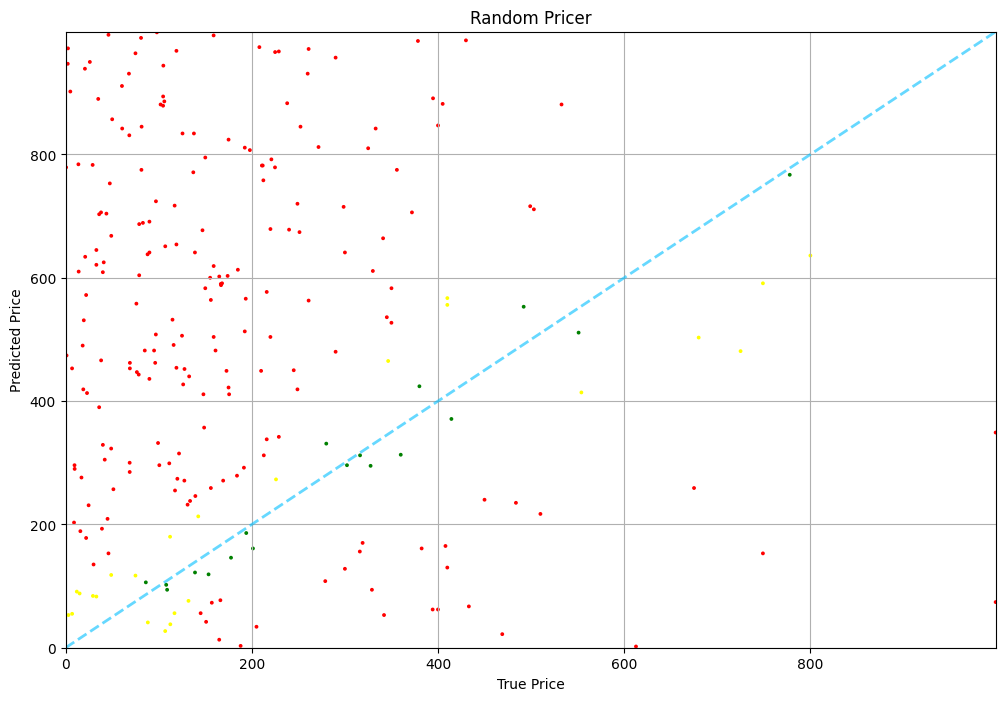

Random Pricer Results:
Mean Absolute Error: $377.88
Mean Squared Logarithmic Error: $3.53
Hits: $18
Standard Deviation of Absolute Error: $254.99
Standard Deviation of Squared Logarithmic Error: $5.47


In [60]:
Tester.test(random_pricer)

### 3.2 Bag of words with Linear Regression

In [29]:
# Use test prompt to predict the price
prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [87]:
# Use CountVectorizer to convert the documents into a matrix of token counts
np.random.seed(42)

vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

LinearRegression()

In [90]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $95.34 | Truth: $97.99 | Error: $2.65 | SLE: $0.00 | Item: Aukilus LCD Display Touch Screen Digitiz...
2: Guess: $148.84 | Truth: $116.92 | Error: $31.92 | SLE: $0.06 | Item: Depo 312-19C6R-AF Replacement Auto Part ...
3: Guess: $180.39 | Truth: $410.00 | Error: $229.61 | SLE: $0.67 | Item: Digital Check CheXpress Scanner WITHOUT ...
4: Guess: $191.35 | Truth: $68.76 | Error: $122.59 | SLE: $1.03 | Item: Greenwald Industries 8-1170 Genuine OEM ...
5: Guess: $187.63 | Truth: $298.59 | Error: $110.96 | SLE: $0.21 | Item: Innovative Mounts 90750-85A Black Bushin...
6: Guess: $76.76 | Truth: $228.99 | Error: $152.23 | SLE: $1.18 | Item: A-Premium Hydro-Boost Power Brake Booste...
7: Guess: $298.78 | Truth: $409.95 | Error: $111.17 | SLE: $0.10 | Item: B&M 70418 Tork Master 2400 Torque Conver...
8: Guess: $87.75 | Truth: $118.99 | Error: $31.24 | SLE: $0.09 | Item: Boxes Fast BFMFL1294K Deluxe Literature ...
9: Guess: $165.78 | Truth: $34.99 | Error: $130.79 | SLE: $2.35 | Item: 7

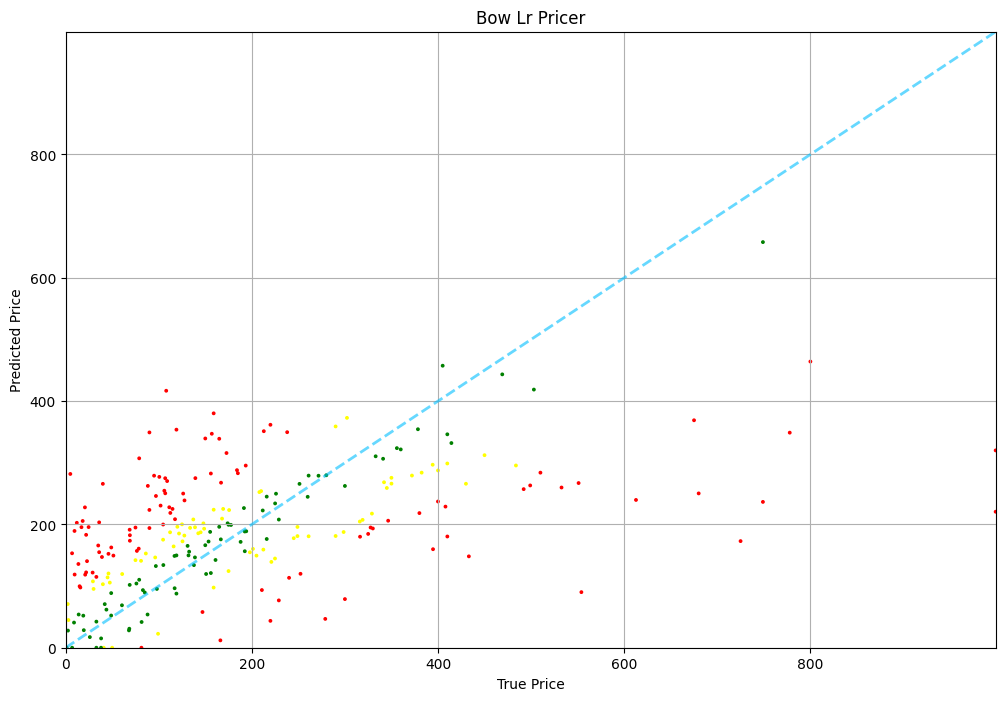

Bow Lr Pricer Results:
Mean Absolute Error: $104.75
Mean Squared Logarithmic Error: $1.22
Hits: $78
Standard Deviation of Absolute Error: $105.62
Standard Deviation of Squared Logarithmic Error: $2.68


In [91]:
Tester.test(bow_lr_pricer)

## 3.3 Word2Vec with Linear Regression

In [30]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [31]:
def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [32]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

LinearRegression()

In [34]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $137.01 | Truth: $97.99 | Error: $39.02 | SLE: $0.11 | Item: Aukilus LCD Display Touch Screen Digitiz...
2: Guess: $136.76 | Truth: $116.92 | Error: $19.84 | SLE: $0.02 | Item: Depo 312-19C6R-AF Replacement Auto Part ...
3: Guess: $265.96 | Truth: $410.00 | Error: $144.04 | SLE: $0.19 | Item: Digital Check CheXpress Scanner WITHOUT ...
4: Guess: $217.77 | Truth: $68.76 | Error: $149.01 | SLE: $1.31 | Item: Greenwald Industries 8-1170 Genuine OEM ...
5: Guess: $163.47 | Truth: $298.59 | Error: $135.12 | SLE: $0.36 | Item: Innovative Mounts 90750-85A Black Bushin...
6: Guess: $175.26 | Truth: $228.99 | Error: $53.73 | SLE: $0.07 | Item: A-Premium Hydro-Boost Power Brake Booste...
7: Guess: $282.12 | Truth: $409.95 | Error: $127.83 | SLE: $0.14 | Item: B&M 70418 Tork Master 2400 Torque Conver...
8: Guess: $112.90 | Truth: $118.99 | Error: $6.09 | SLE: $0.00 | Item: Boxes Fast BFMFL1294K Deluxe Literature ...
9: Guess: $92.05 | Truth: $34.99 | Error: $57.06 | SLE: $0.90 | Item: 7

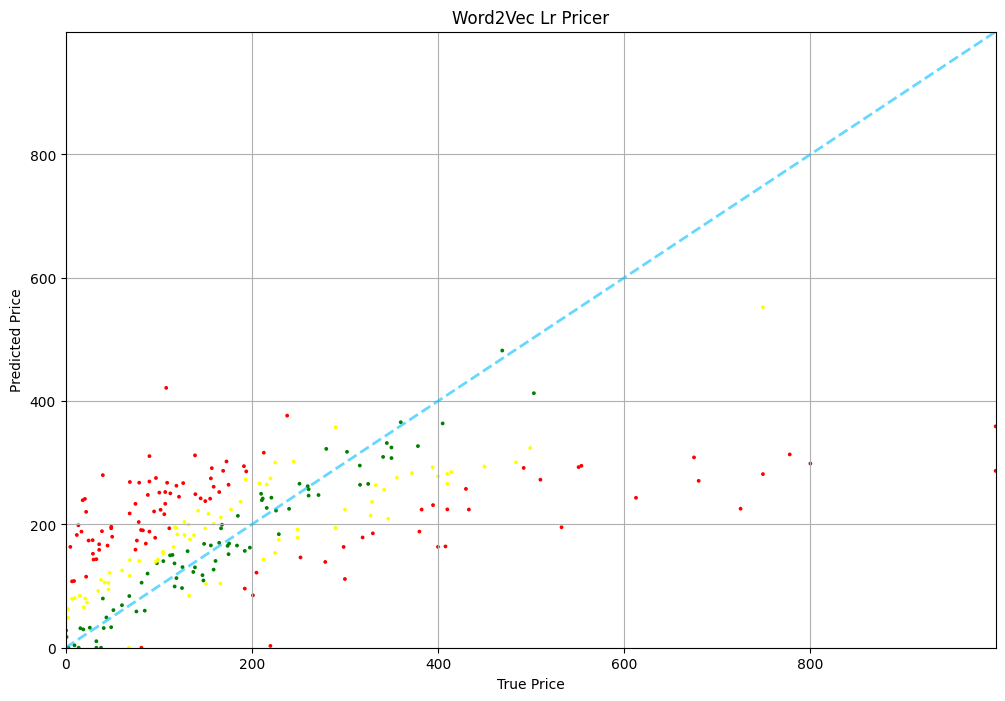

Word2Vec Lr Pricer Results:
Mean Absolute Error: $100.84
Mean Squared Logarithmic Error: $1.18
Hits: $77
Standard Deviation of Absolute Error: $101.22
Standard Deviation of Squared Logarithmic Error: $2.73


In [35]:
Tester.test(word2vec_lr_pricer)

### 3.4 Support Vector

In [36]:
# Support Vector Machines

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

LinearSVR()

In [37]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $88.51 | Truth: $97.99 | Error: $9.48 | SLE: $0.01 | Item: Aukilus LCD Display Touch Screen Digitiz...
2: Guess: $120.51 | Truth: $116.92 | Error: $3.59 | SLE: $0.00 | Item: Depo 312-19C6R-AF Replacement Auto Part ...
3: Guess: $175.19 | Truth: $410.00 | Error: $234.81 | SLE: $0.72 | Item: Digital Check CheXpress Scanner WITHOUT ...
4: Guess: $170.47 | Truth: $68.76 | Error: $101.71 | SLE: $0.81 | Item: Greenwald Industries 8-1170 Genuine OEM ...
5: Guess: $128.44 | Truth: $298.59 | Error: $170.15 | SLE: $0.70 | Item: Innovative Mounts 90750-85A Black Bushin...
6: Guess: $163.83 | Truth: $228.99 | Error: $65.16 | SLE: $0.11 | Item: A-Premium Hydro-Boost Power Brake Booste...
7: Guess: $232.42 | Truth: $409.95 | Error: $177.53 | SLE: $0.32 | Item: B&M 70418 Tork Master 2400 Torque Conver...
8: Guess: $95.72 | Truth: $118.99 | Error: $23.27 | SLE: $0.05 | Item: Boxes Fast BFMFL1294K Deluxe Literature ...
9: Guess: $62.24 | Truth: $34.99 | Error: $27.25 | SLE: $0.32 | Item: 72" 

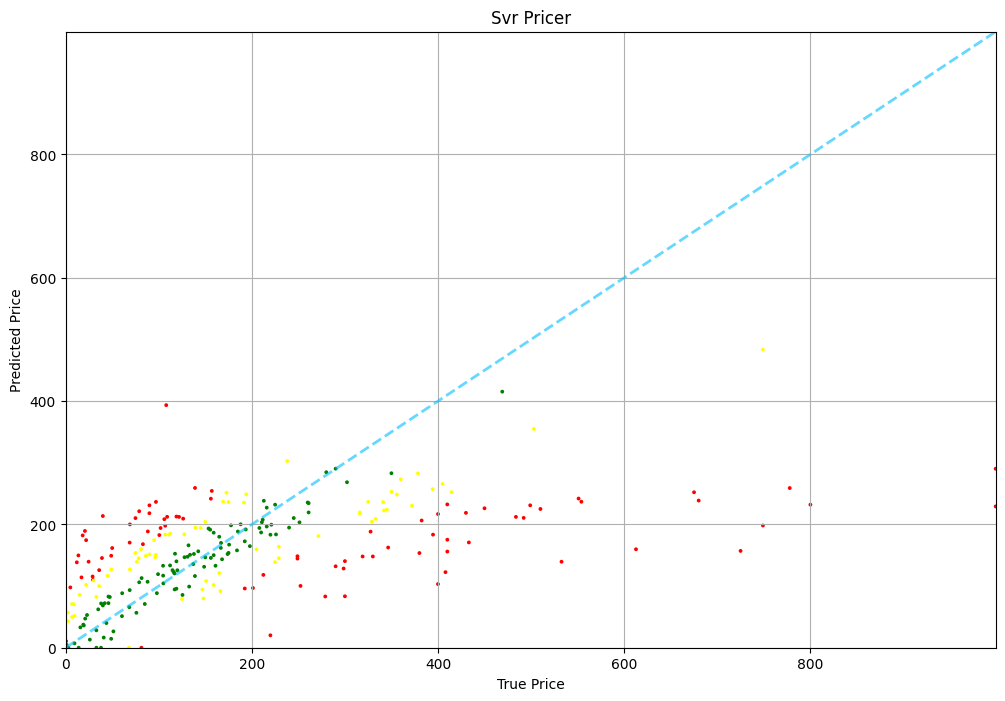

Svr Pricer Results:
Mean Absolute Error: $96.30
Mean Squared Logarithmic Error: $0.98
Hits: $102
Standard Deviation of Absolute Error: $116.65
Standard Deviation of Squared Logarithmic Error: $2.35


In [38]:
Tester.test(svr_pricer)

## 3.5 Random Forest

In [39]:
# And the powerful Random Forest regression

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

RandomForestRegressor(n_jobs=8, random_state=42)

In [42]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

1: Guess: $138.95 | Truth: $97.99 | Error: $40.96 | SLE: $0.12 | Item: Aukilus LCD Display Touch Screen Digitiz...
2: Guess: $130.30 | Truth: $116.92 | Error: $13.38 | SLE: $0.01 | Item: Depo 312-19C6R-AF Replacement Auto Part ...
3: Guess: $340.63 | Truth: $410.00 | Error: $69.37 | SLE: $0.03 | Item: Digital Check CheXpress Scanner WITHOUT ...
4: Guess: $104.19 | Truth: $68.76 | Error: $35.43 | SLE: $0.17 | Item: Greenwald Industries 8-1170 Genuine OEM ...
5: Guess: $281.79 | Truth: $298.59 | Error: $16.80 | SLE: $0.00 | Item: Innovative Mounts 90750-85A Black Bushin...
6: Guess: $204.23 | Truth: $228.99 | Error: $24.76 | SLE: $0.01 | Item: A-Premium Hydro-Boost Power Brake Booste...
7: Guess: $316.71 | Truth: $409.95 | Error: $93.24 | SLE: $0.07 | Item: B&M 70418 Tork Master 2400 Torque Conver...
8: Guess: $98.43 | Truth: $118.99 | Error: $20.56 | SLE: $0.04 | Item: Boxes Fast BFMFL1294K Deluxe Literature ...
9: Guess: $44.64 | Truth: $34.99 | Error: $9.65 | SLE: $0.06 | Item: 72" Ho

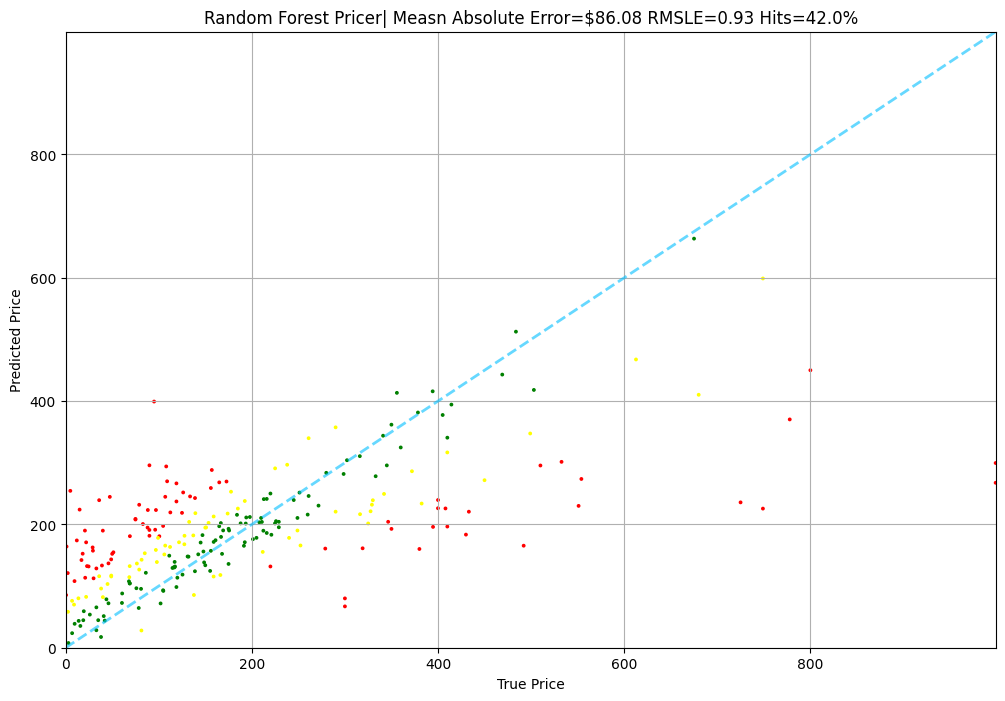

In [43]:
Tester.test(random_forest_pricer)